In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer

#from pandas_profiling import ProfileReport

## Pima Indians Diabetes Database

El objetivo del conjunto de datos es predecir si un paciente tiene diabetes o no, basándose en ciertas mediciones de diagnóstico incluidas en el conjunto de datos.

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [2]:
#convertir un csv en un dataframe
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Feature description

Pregnancies: Número de veces embarazada.

Glucose: Concentración de Glucosa en Plasma a las 2 Horas en una Prueba de Tolerancia Oral a la Glucosa (GTT).

BloodPressure: Presión Arterial Diastólica (mm Hg).

SkinThickness: Grosor del Pliegue Cutáneo del Tríceps (mm).

Insulin: Insulina en Suero a las 2 Horas (µU/ml).

BMI: Índice de Masa Corporal (Peso en kg / (Altura en cm)^2).

DiabetesPedigreeFunction: Función de Pedigrí de Diabetes.

Age: Edad (años).

## Análisis de datos:

En primer lugar vamos a analizar la información del dataset

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


Podemos observar que no tenemos valores no nulos, por lo que en principio no vamos a utilizar técnicas de imputación.

Todas nuestras features a priori son numéricas.

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Utilizamos la función ProfileReport() de la librería pandas_profiling para ver la información de nuestras features en un archivo html.

In [6]:
#profile = ProfileReport(df)

In [7]:
#profile.to_file("informe.html")

Analizamos las distribuciones:

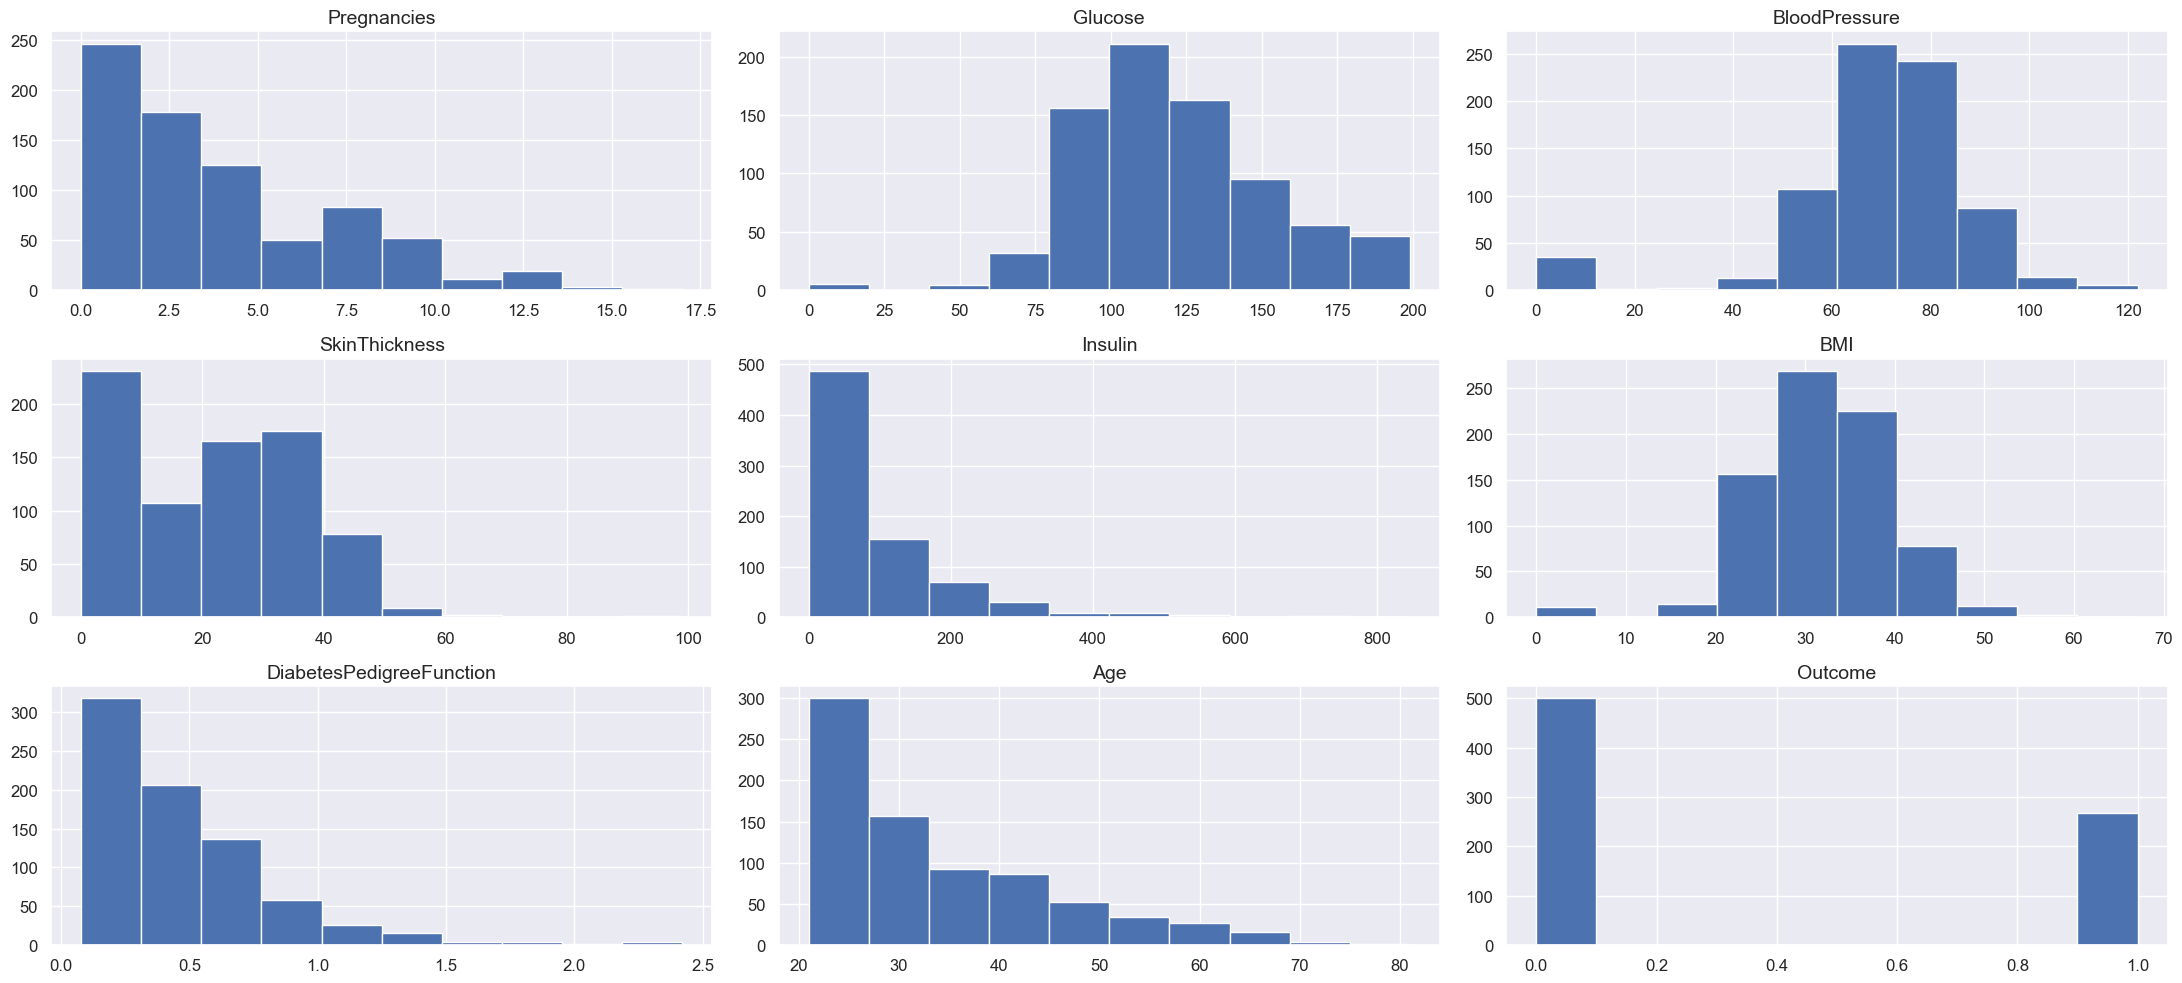

In [8]:
def display_dataset_distributions(dataset,bins=10,figsize=(22,10)):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12 ,figsize=figsize, bins=bins)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()
    
display_dataset_distributions(df)

Vamos a observar si nuestras variables estan correlacionadas:

<Axes: >

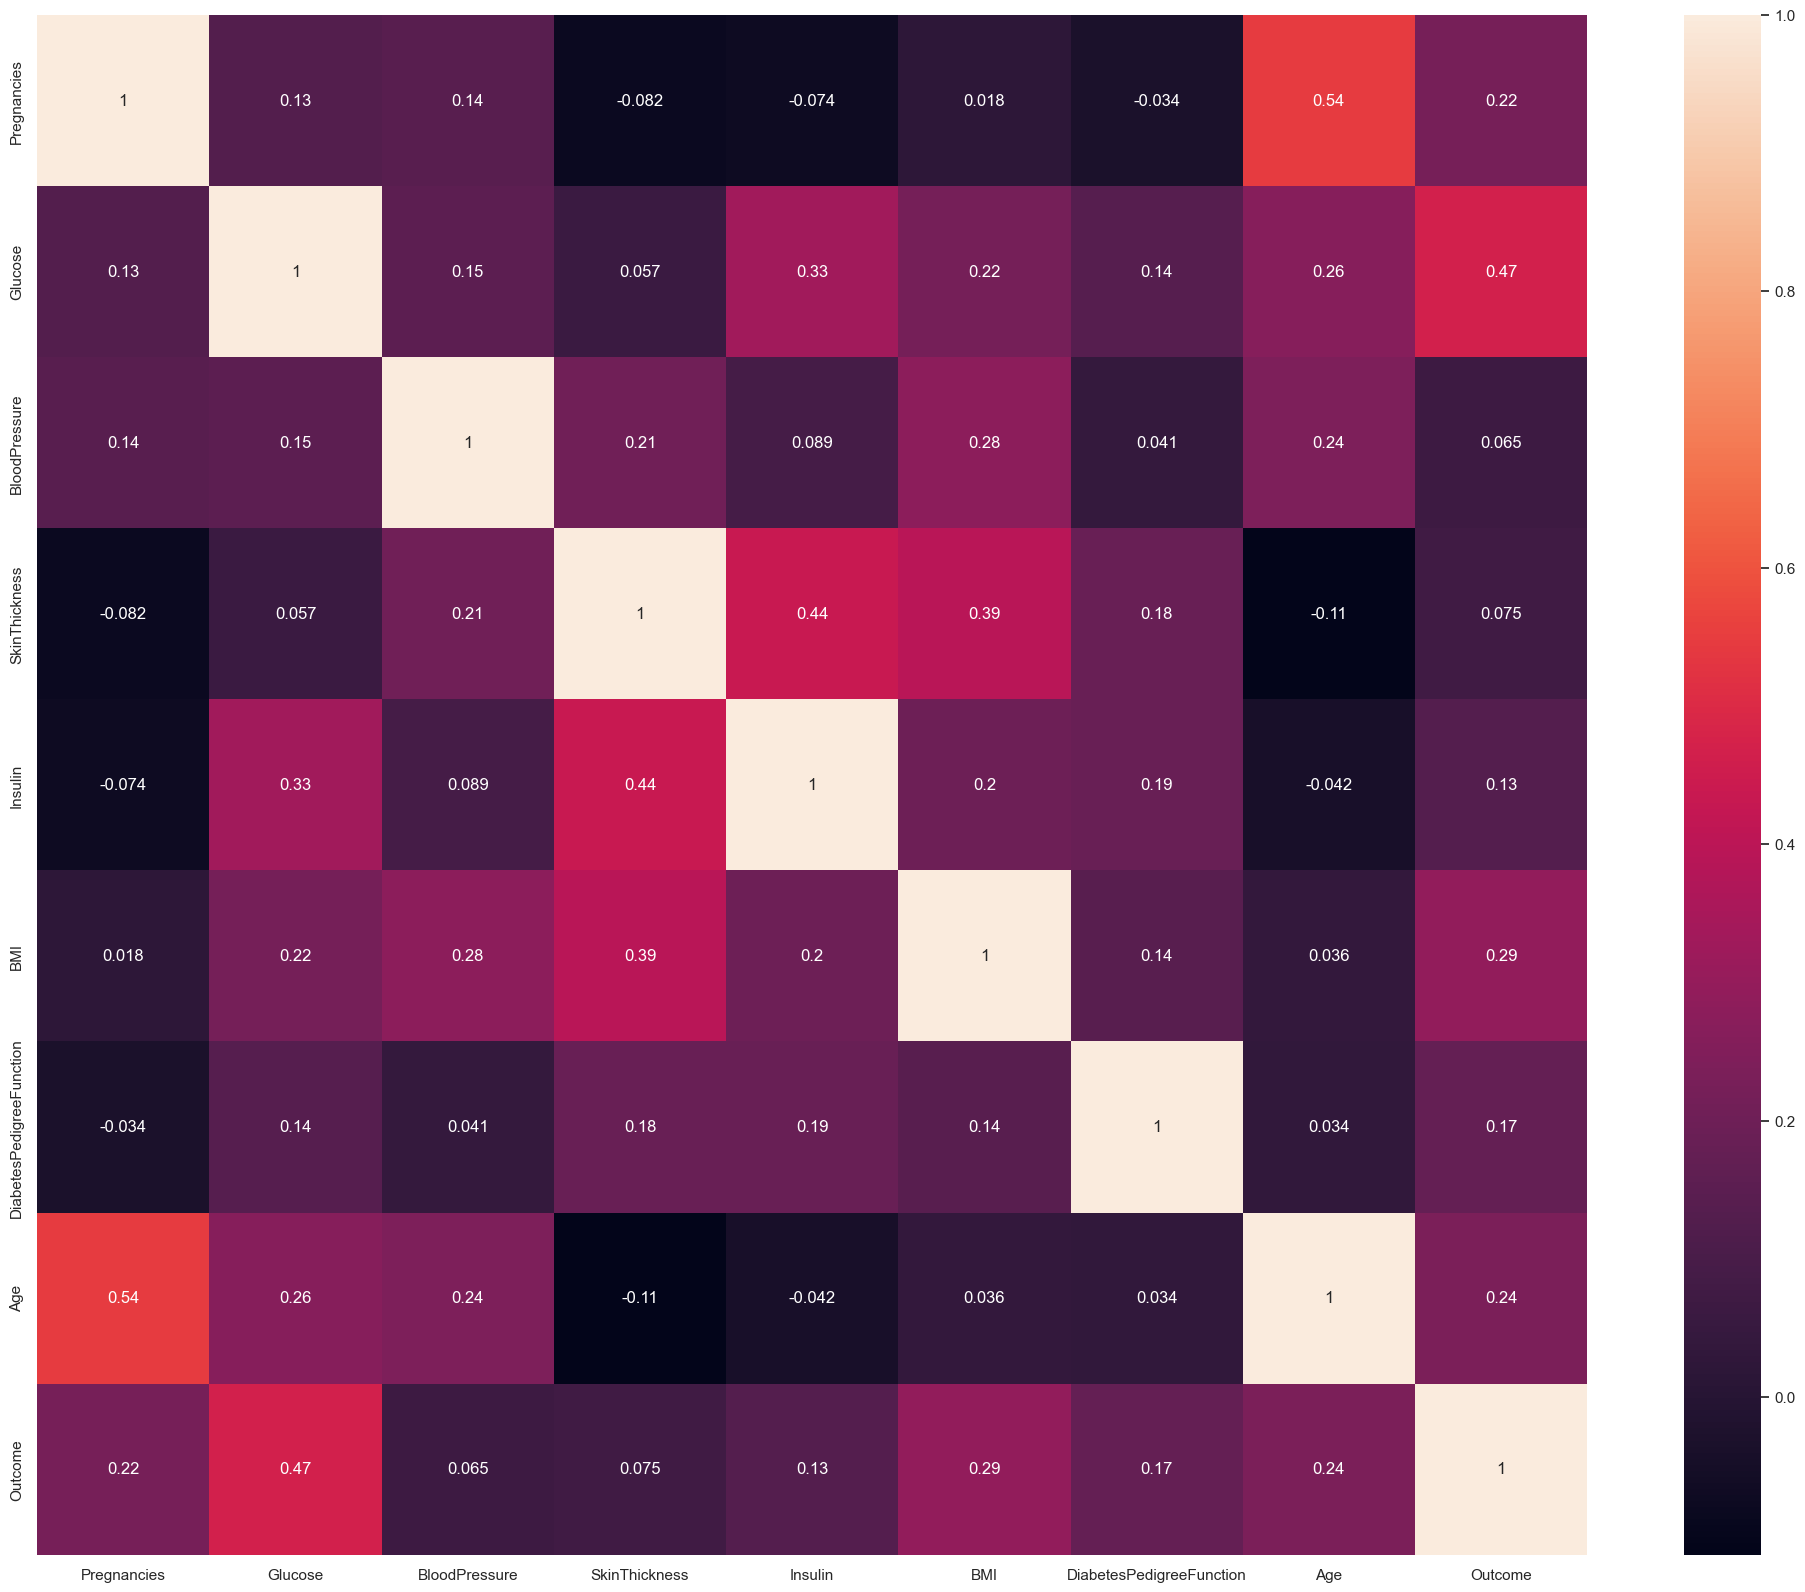

In [9]:
fig = plt.figure(figsize=(25,20))
sns.heatmap(df.corr(), annot=True)

Estableciendo un umbral de 0.7, vemos que no es necesario eliminar features porque ninguna esta tan correlacionada.

La que más se correlaciona con nuestra salida es "Glucose"

In [10]:
# columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# bc = PowerTransformer(method='yeo-johnson')
# df_bc = bc.fit_transform(df[columns])
# df_bc = pd.DataFrame(df_bc)

Vemos si la salida está balanceada:

Outcome
0    500
1    268
Name: count, dtype: int64


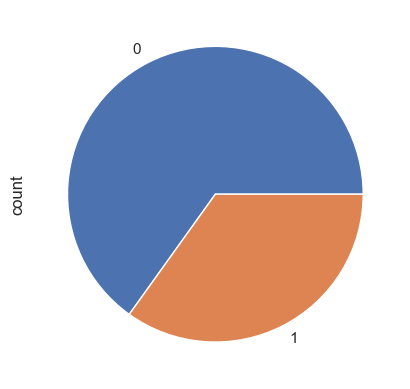

In [11]:
df.Outcome.value_counts().plot(kind ='pie')
print(df.Outcome.value_counts())

La variable a predecir (Outcome) está bastante desbalanceada. Para solucionar este problema se aplicó un proceso de upsampling de muestras, que consiste en repetir
muestras del dataset de la variable con menor ocurrencia, hasta que las clases de salida queden con igual (o parecida) cantidad de datos.

Outcome
1    500
0    500
Name: count, dtype: int64

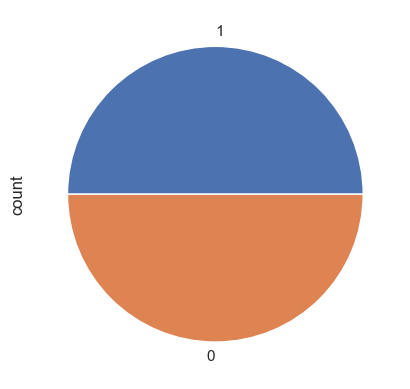

In [12]:
from sklearn.utils import resample
from sklearn.utils import shuffle

df_upsampled = resample(df[df['Outcome']==1], replace = True, 
                            n_samples = df.Outcome.value_counts().max()-df.Outcome.value_counts().min()) 

df = pd.concat([df, df_upsampled]) 
df = shuffle(df)

df.Outcome.value_counts().plot(kind ='pie')
print(df.Outcome.value_counts())

Antes de realizar cualquier exploración sobre el dataset, debe separarse en grupos de Train y Test, a fin de no influenciar nuestras decisiones con el conjunto de datos Test. Los datos de Test no se utilizarán hasta el final del trabajo, en donde se realiza la evaluación final del modelo seleccionado. En la división de datos se deja una proporción de 80% para Train y 20% para Test.

In [13]:
from sklearn.model_selection import train_test_split

df = df[df['Outcome'].notna()]

y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Outcome'], axis=1),
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
    )

print("X_train.shape, X_test.shape = ")
print(X_train.shape, X_test.shape)

print("% of Outcome in original dataset: "+str((df['Outcome']==1).sum()/df.shape[0]*100))
print("% of Outcome in y_train: "+str((y_train==1).sum()/y_train.shape[0]*100))
print("% of Outcome in y_test: "+str((y_test==1).sum()/y_test.shape[0]*100))

X_train.shape, X_test.shape = 
(800, 8) (200, 8)
% of Outcome in original dataset: 50.0
% of Outcome in y_train: 50.0
% of Outcome in y_test: 50.0


In [14]:
X_train['Outcome']=y_train
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
506,0,180,90,26,90,36.5,0.314,35,1
11,10,168,74,0,0,38.0,0.537,34,1
321,3,112,74,30,0,31.6,0.197,25,1
131,9,122,56,0,0,33.3,1.114,33,1
535,4,132,0,0,0,32.9,0.302,23,1
...,...,...,...,...,...,...,...,...,...
219,5,112,66,0,0,37.8,0.261,41,1
655,2,155,52,27,540,38.7,0.240,25,1
243,6,119,50,22,176,27.1,1.318,33,1
453,2,119,0,0,0,19.6,0.832,72,0


C:\Users\cbureu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


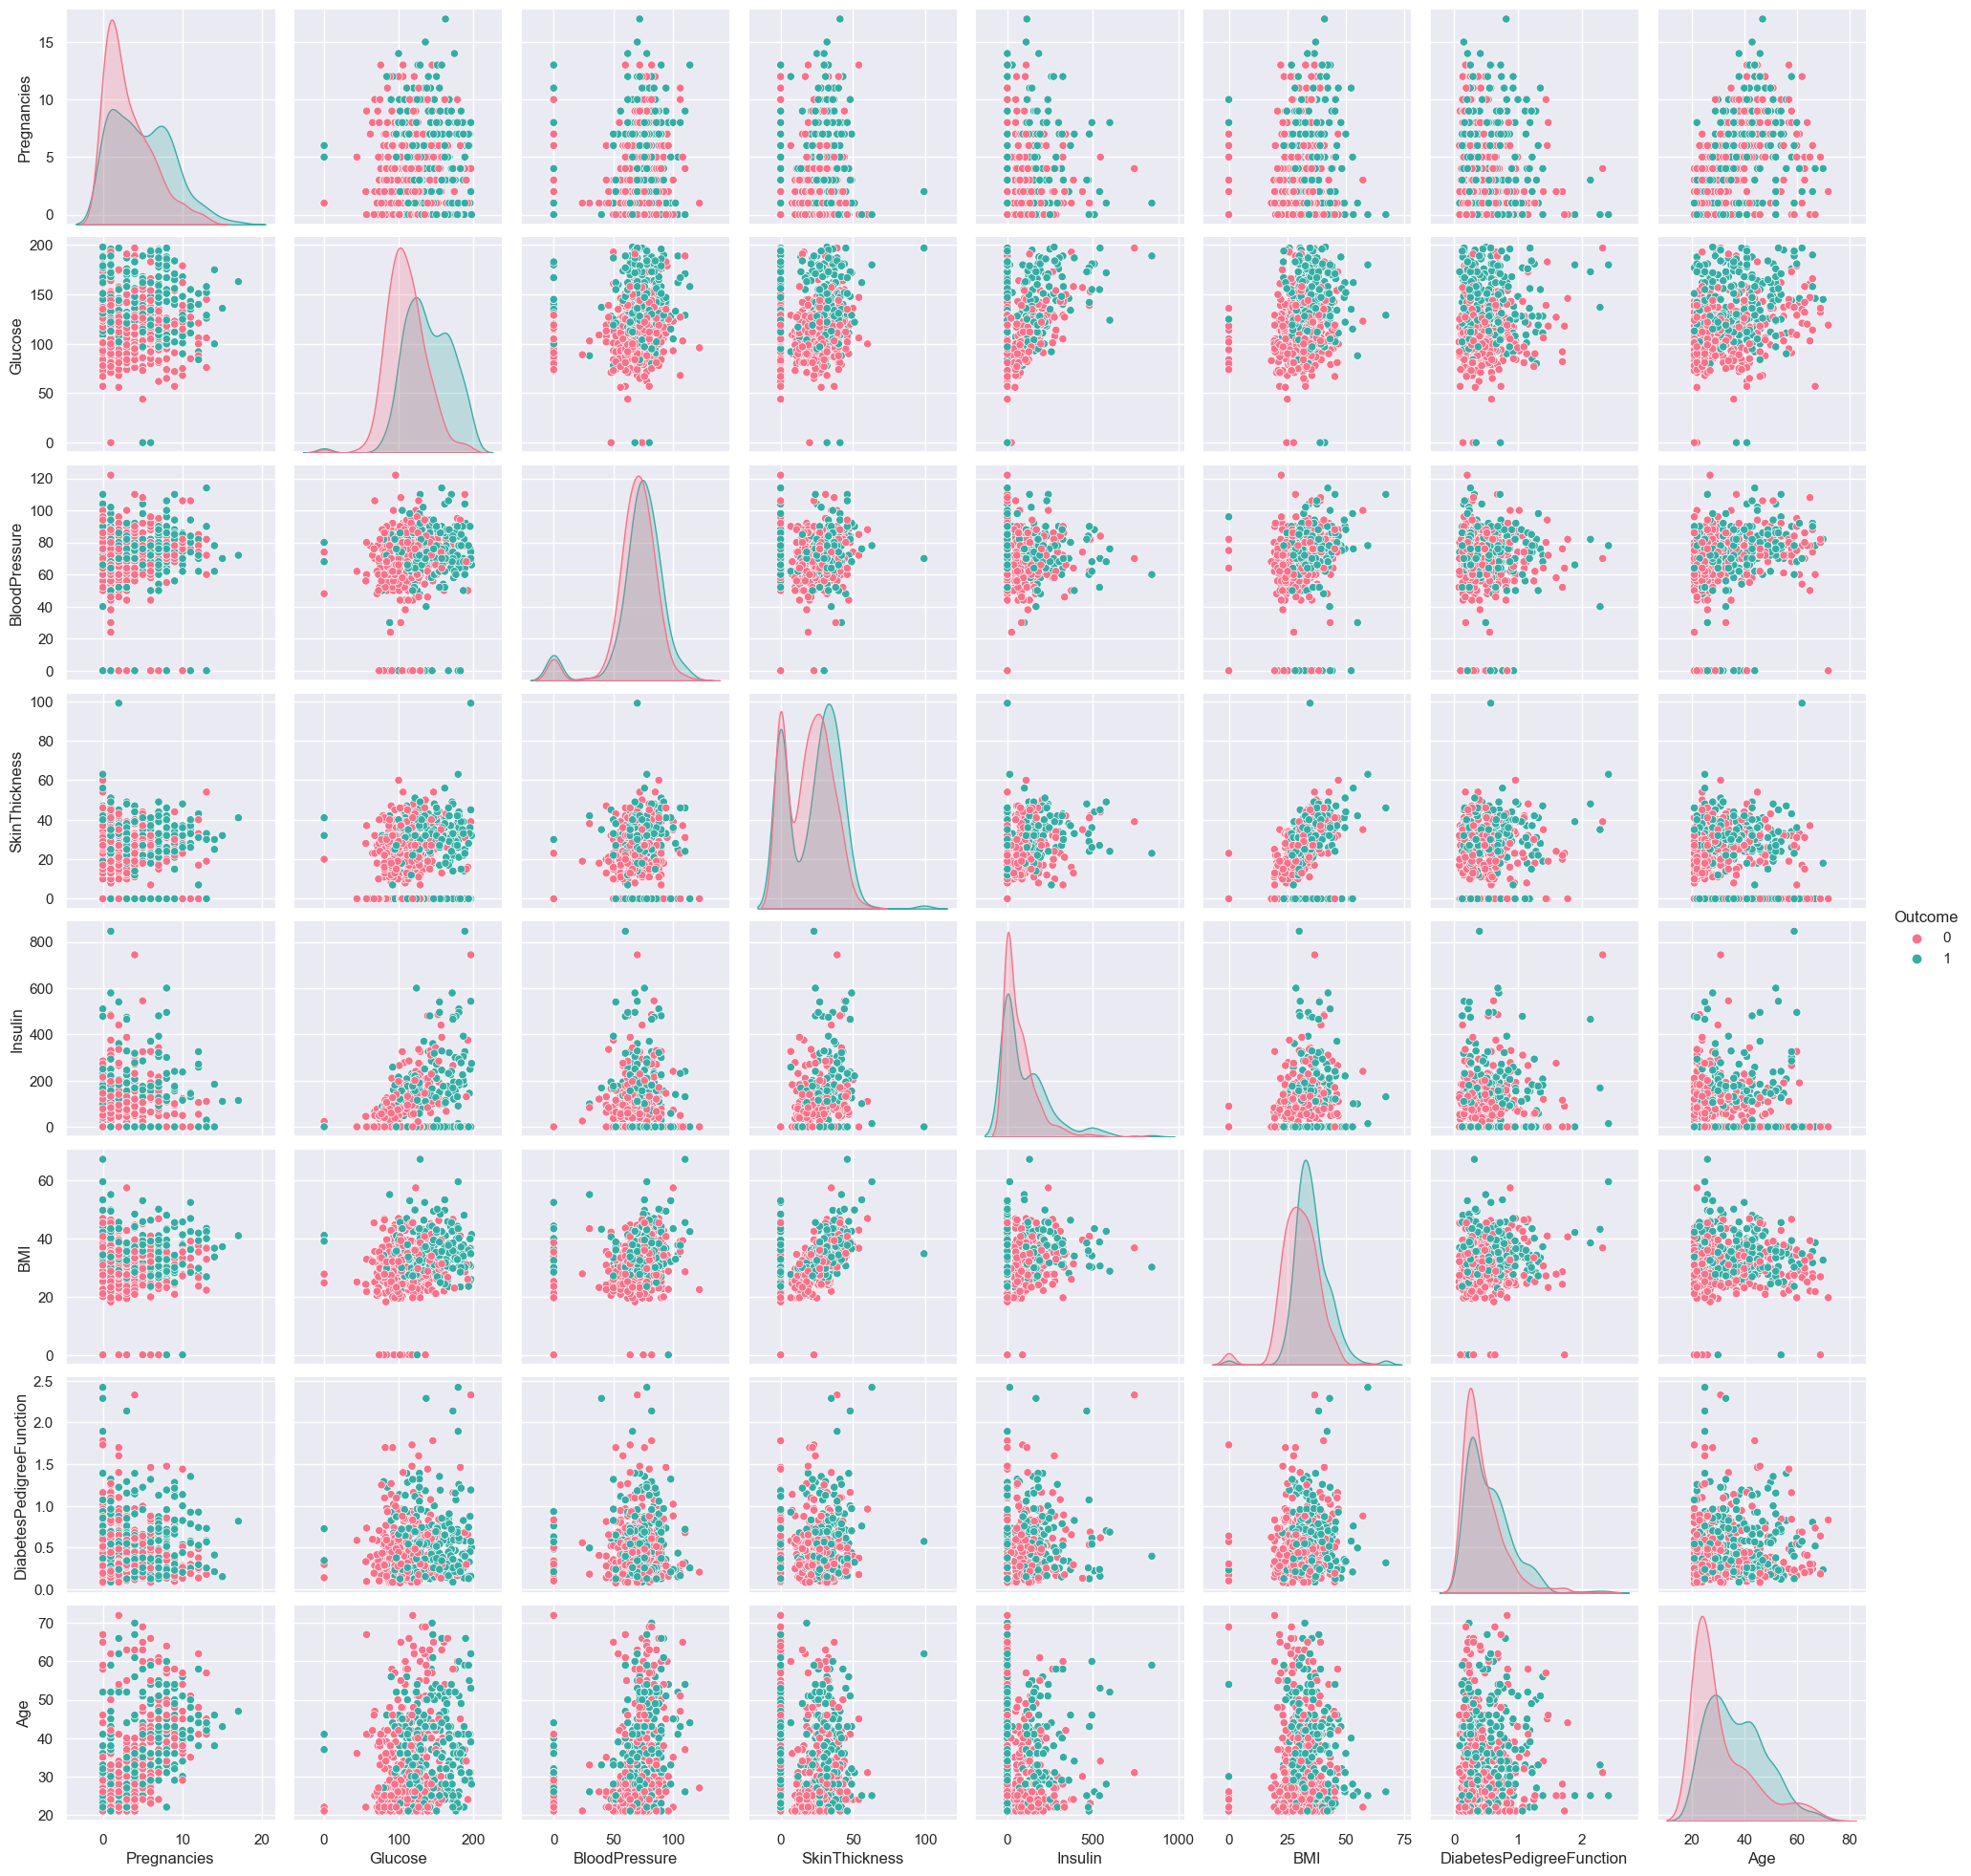

In [15]:
sns.pairplot(X_train,hue="Outcome",palette="husl")

## Outliers

El siguiente paso propuesto es la eliminación de outliers. Para esto, se graficaron los histogramas, qqplot y diagrama box&Whiskers de las variables de entrada.

In [16]:
def outlier_diagnostic_plots(df, variable):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    # histograma
    sns.histplot(df[variable], bins=30,ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    # qqplot    
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

    fig.suptitle(variable, fontsize=16)

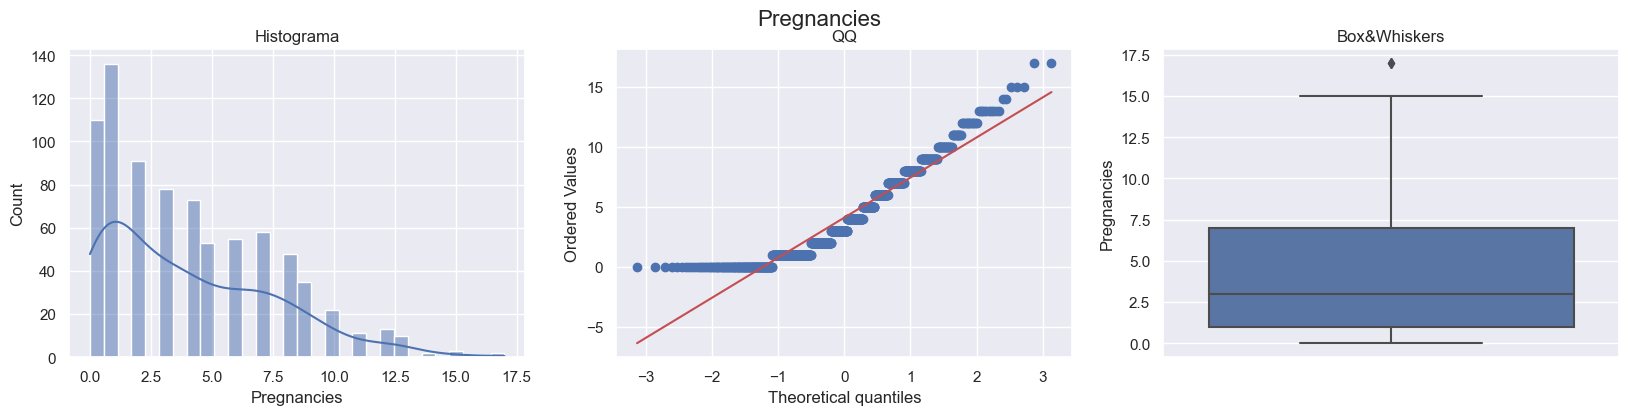

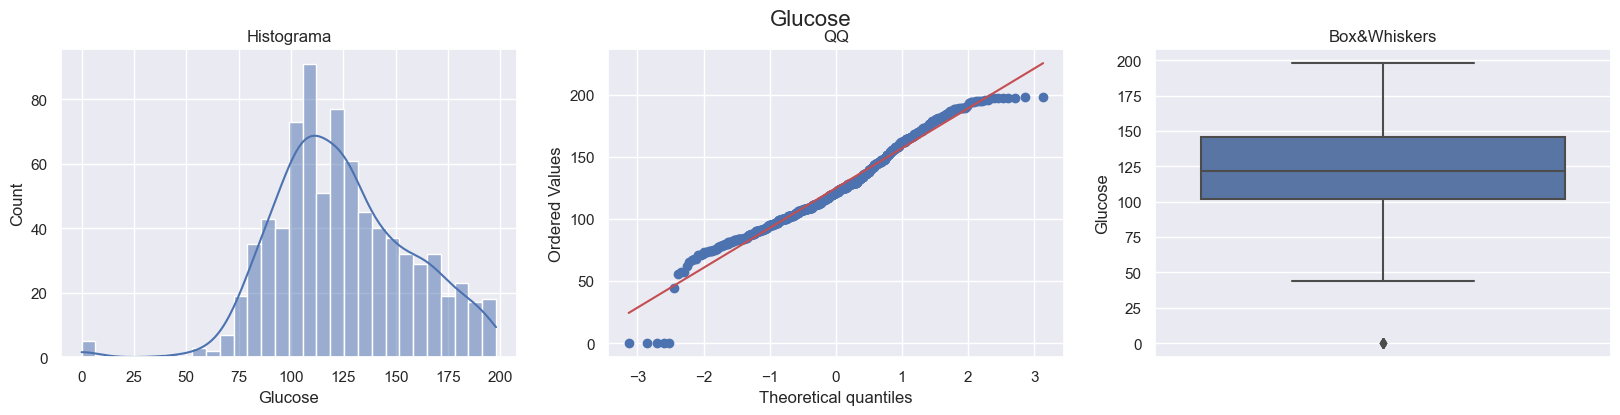

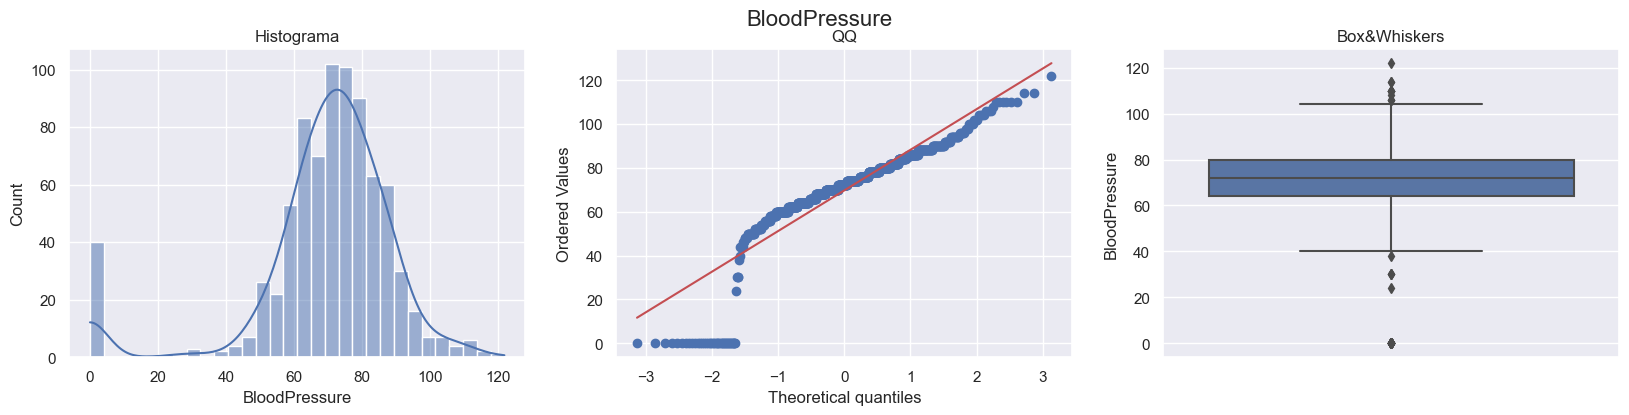

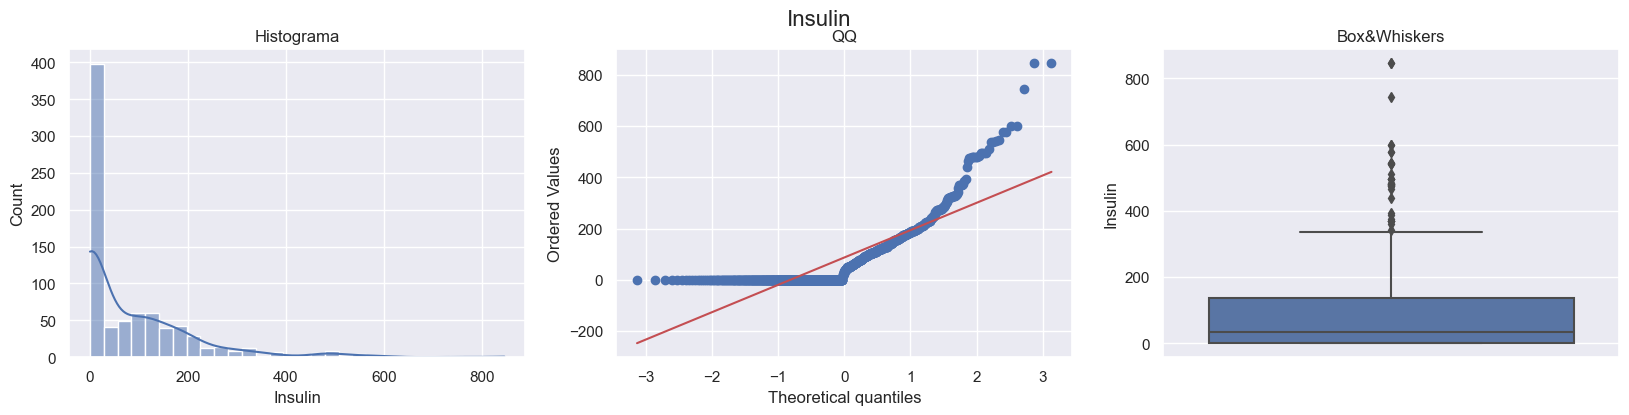

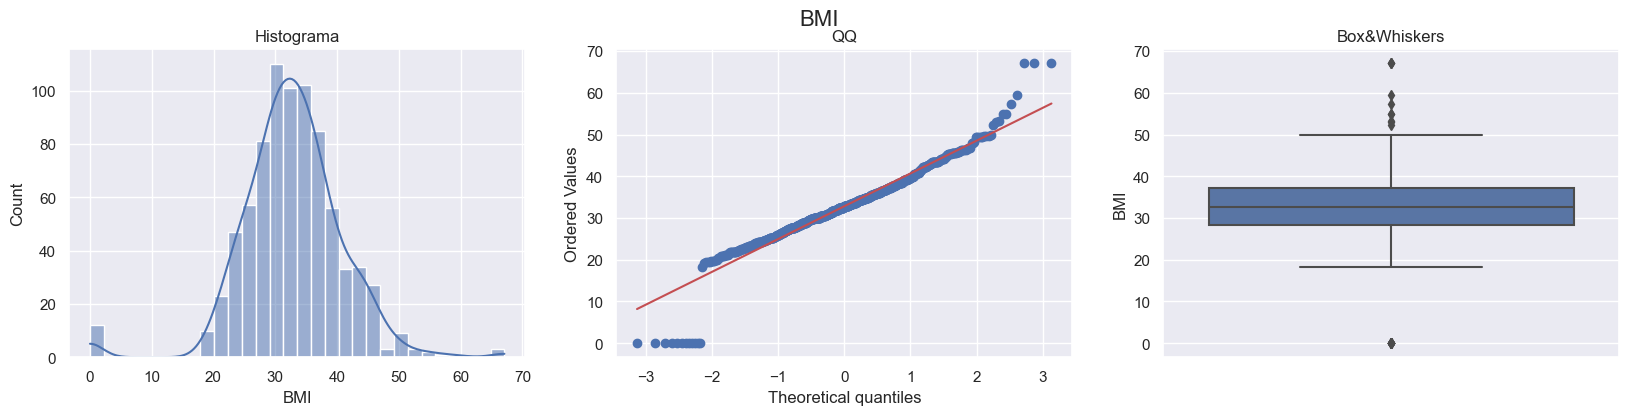

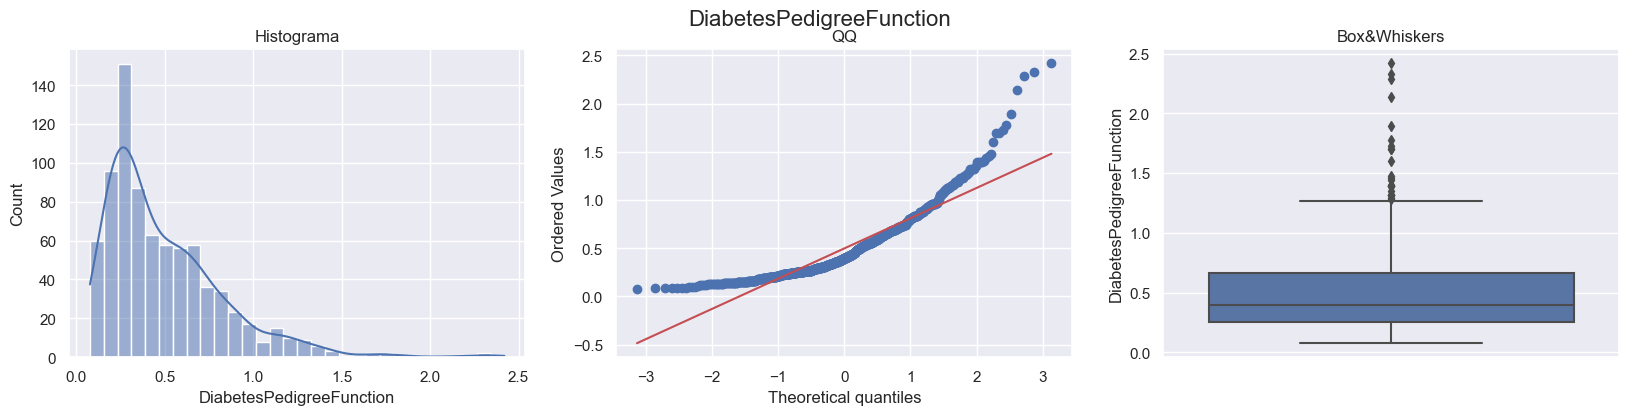

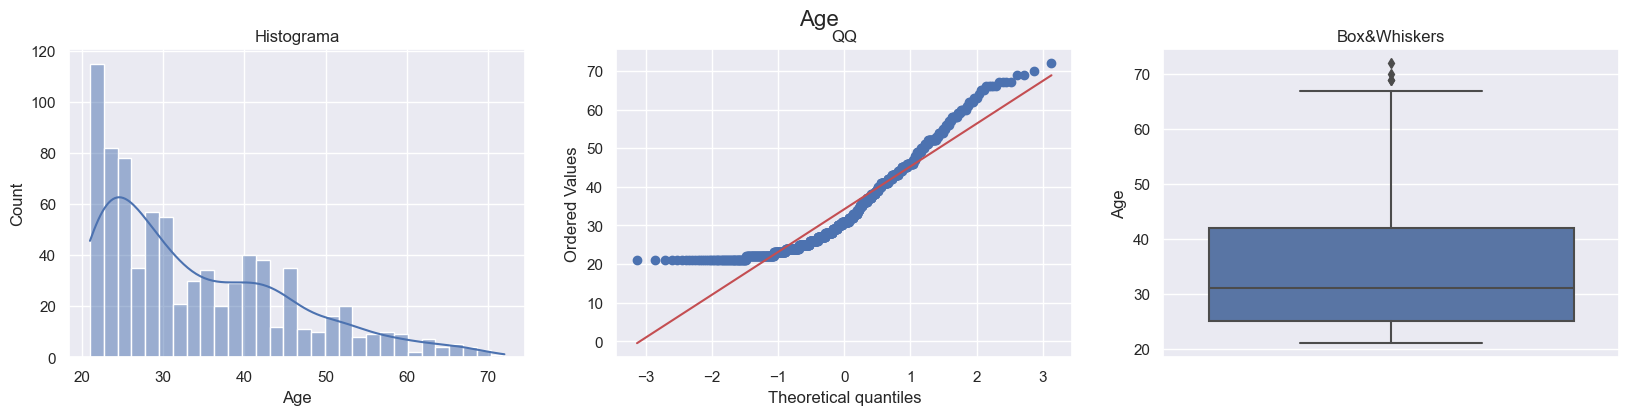

In [17]:
norm_col = [
    'Pregnancies',
    'Glucose', 
    'BloodPressure', 
    'Insulin', 
    'BMI',
    'DiabetesPedigreeFunction', 
    'Age',
]

for col in norm_col:
    outlier_diagnostic_plots(X_train, col)

El enfoque utilizados para el tratamiento de outliers fue una situación de compromiso entre eliminación de filas y asignación de valores a un umbral:
- Las filas con outliers mayores a 1.8*IQR fueron eliminadas del dataset.
- A los outliers por encima de 1.5*IQR se les asignó ese valor (1.5IQR) recortando la distribución en ese punto.

In [18]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary
    
def transform_outliers(df, norm_col, threshold_capped=1.5, threshold_trimmed=1.8, use_manual_limits=False, 
                        upper_limit_trim=0, lower_limit_trim=0, upper_limit_cap=0, lower_limit_cap=0):
    # Trimming and capping outliers
    outliers_total = np.array(np.repeat(False,df.shape[0]))
    X_train_capped = df.copy()
    for col in norm_col:
        
        if use_manual_limits:
            upper_limit, lower_limit = upper_limit_trim, lower_limit_trim
        else:
            upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_trimmed)

        outliers = np.where(df[col] > upper_limit, True,
                            np.where(df[col] < lower_limit, True, False))                        
        outliers_total = np.logical_or(outliers_total, outliers)
        
        print(str(col) + " outliers = "+str(outliers.sum()))
        
        if use_manual_limits:
            upper_limit, lower_limit = upper_limit_cap, lower_limit_cap
        else:
            upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_capped)

        X_train_capped[col] = np.where(df[col] > upper_limit, upper_limit,
                            np.where(df[col] < lower_limit, lower_limit, X_train_capped[col]))

    print("Total outliers = "+str(outliers_total.sum()))
    X_train_trimmed = X_train_capped.loc[~(outliers_total)]

    return X_train_trimmed

Pregnancies outliers = 0
Glucose outliers = 5
BloodPressure outliers = 53
Insulin outliers = 28
BMI outliers = 21
DiabetesPedigreeFunction outliers = 13
Age outliers = 0
Total outliers = 104


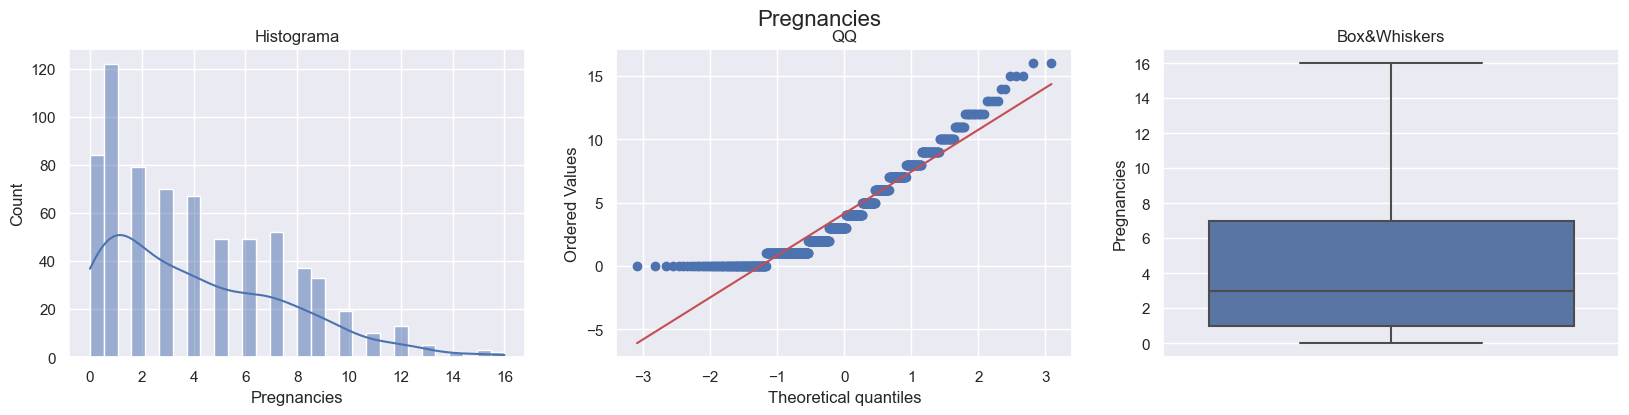

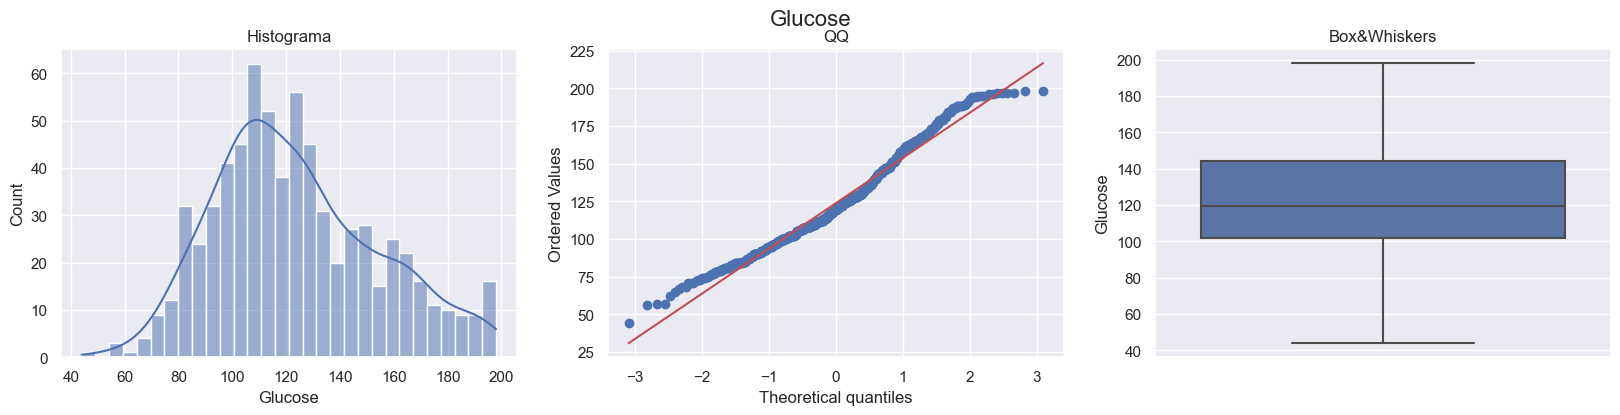

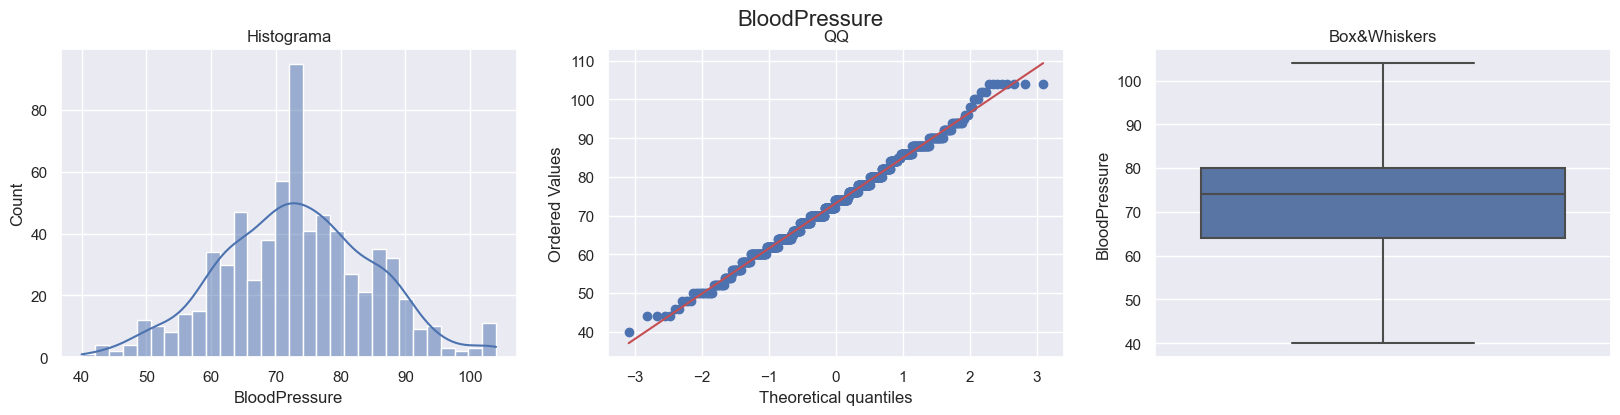

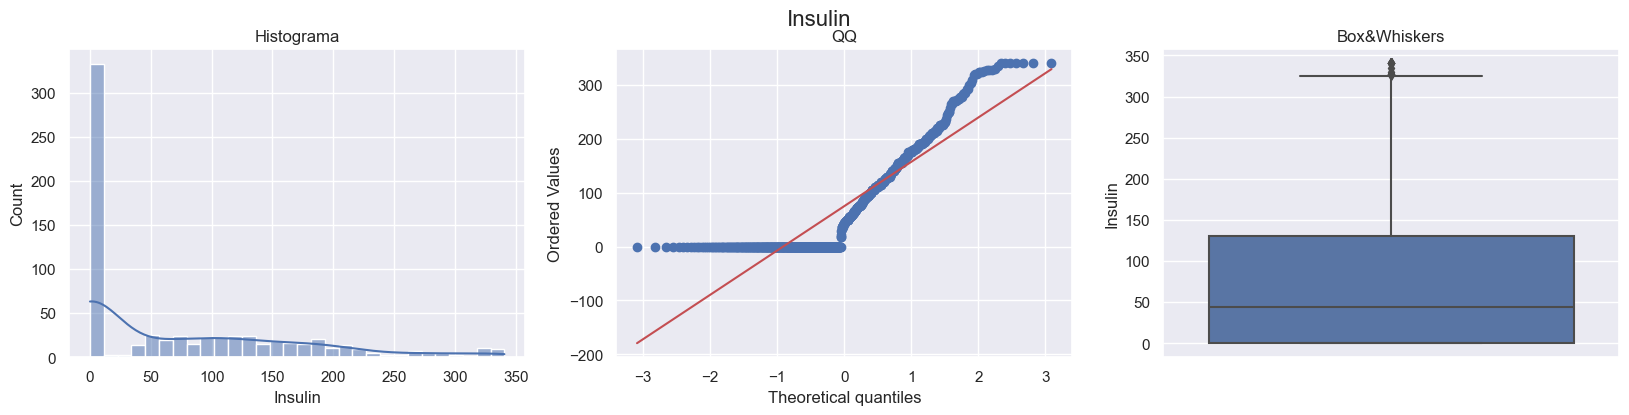

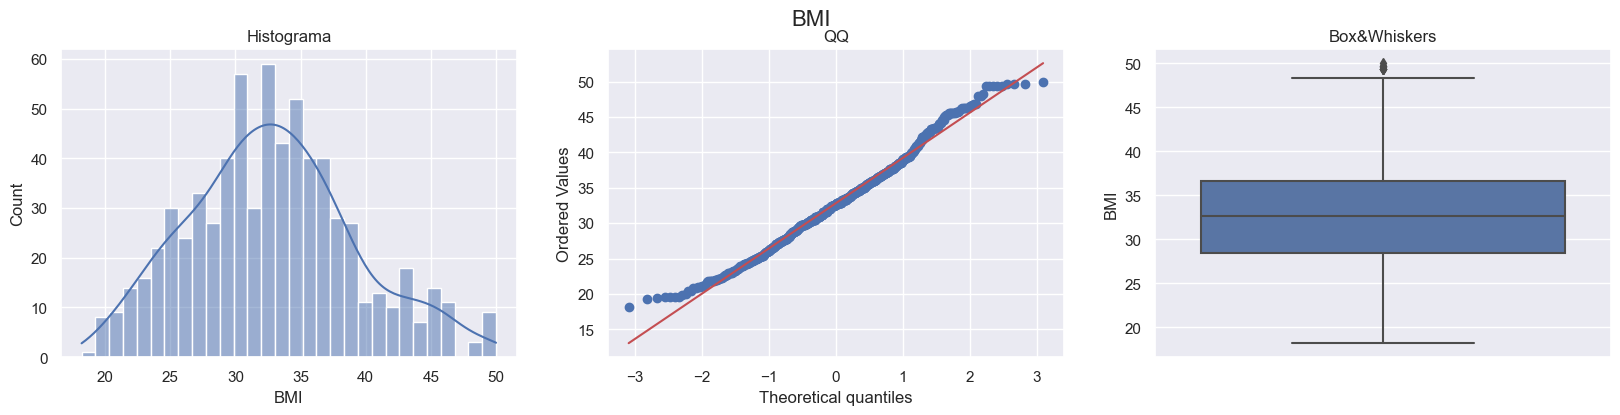

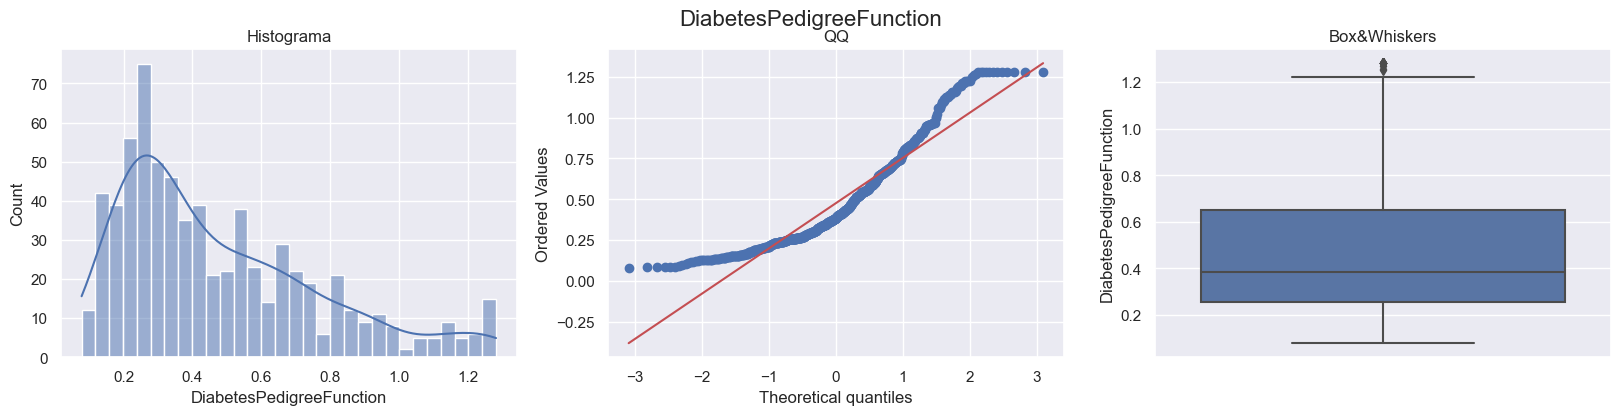

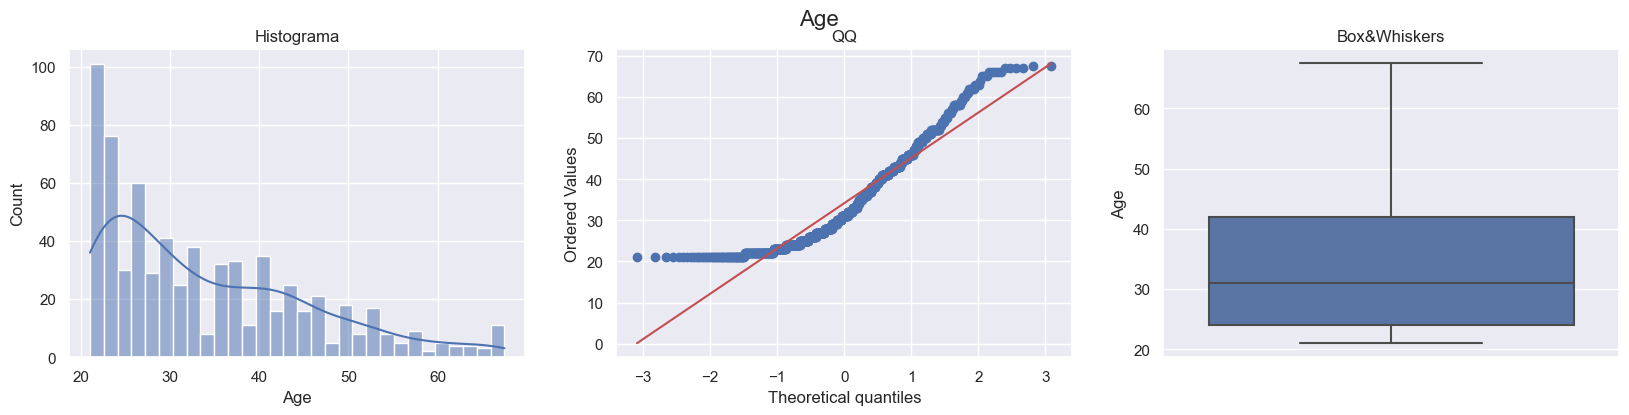

In [19]:
X_train_trimmed = transform_outliers(X_train, norm_col)

for col in norm_col:
    outlier_diagnostic_plots(X_train_trimmed, col)
    
X_train = X_train_trimmed

No se observan fuertes correlaciones entre las features y la salida

## Modelos y evaluación


In [20]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, auc, roc_curve

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [21]:
y_train = X_train['Outcome']

X = X_train.drop(['Outcome'], axis=1)
y = y_train    
print(len(y_train))
print(len(X_train))
print(len(y))
print(len(X))

696
696
696
696


Se divide el dataset en train, test y validacion. El conjunto de validación se utiliza para selección de hiperparámetros y para comparar resultados entre modelos.

In [22]:
X = X_train.drop(['Outcome'], axis=1)
y = y_train               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.1, shuffle=True, stratify=y_train)

print("Train:", len(X_train))
print("Tests:", len(X_test))
print("Validation:", len(X_val))

Train: 500
Tests: 140
Validation: 56


En primer lugar, se decide entrenar el set de datos con varios modelos diferentes para evaluar cuál es el que nos da las mejores métricas. Principalmente el score que nos interesa es el Recall, dado que si hay una persona enferma debo diagnosticarla bien.

In [23]:
def evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=False, Model='logistic'):
    if Scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    if Model == 'logistic':
        model = LogisticRegression(max_iter=1000)
    elif Model == 'random_forest':
        model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    elif Model == 'gradient_boosting':
        model = GradientBoostingClassifier()
    elif Model == 'svm':
        model = SVC(kernel='linear', probability=True)
    elif Model == 'knn':  
        model = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=2)
    elif Model == 'decision_tree_classifier':  
        model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    else:
        raise ValueError("Model type not recognized")

    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    #sns.histplot(data=y_pred_val)

    accuracy_val = accuracy_score(y_pred_val, y_val)
    precision_val = precision_score(y_pred_val, y_val)
    recall_val = recall_score(y_pred_val, y_val)
    f1_val = f1_score(y_pred_val, y_val)

    metrics_val_df = pd.DataFrame({
        'Modelo': [Model],
        'Scale': [Scale],
        'Accuracy': [accuracy_val],
        'Precision': [precision_val],
        'Recall': [recall_val],
        'F1': [f1_val]
    })

    # Calculamos la probabilidad del modelo
    prob_total = model.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

    # Realizamos la curva roc
    fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

    # Ploteamos la curva
    plt.plot(fpr_total, tpr_total, label={Model}, linewidth=2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.legend()

    # Calculamos el auc
    print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

    accuracy_test = accuracy_score(y_pred_test, y_test)

    return metrics_val_df


Modelo con todos los atributos AUC: 0.840890522875817
Modelo con todos los atributos AUC: 0.9107434640522876
Modelo con todos los atributos AUC: 0.8884803921568627
Modelo con todos los atributos AUC: 0.8429330065359477
Modelo con todos los atributos AUC: 0.789624183006536
Modelo con todos los atributos AUC: 0.8578431372549019
                     Modelo  Scale  Accuracy  Precision    Recall        F1
0                  logistic   True  0.696429   0.555556  0.750000  0.638298
1             random_forest   True  0.857143   0.888889  0.827586  0.857143
2         gradient_boosting   True  0.785714   0.851852  0.741935  0.793103
3                       svm   True  0.696429   0.555556  0.750000  0.638298
4                       knn   True  0.660714   0.703704  0.633333  0.666667
5  decision_tree_classifier   True  0.857143   0.962963  0.787879  0.866667


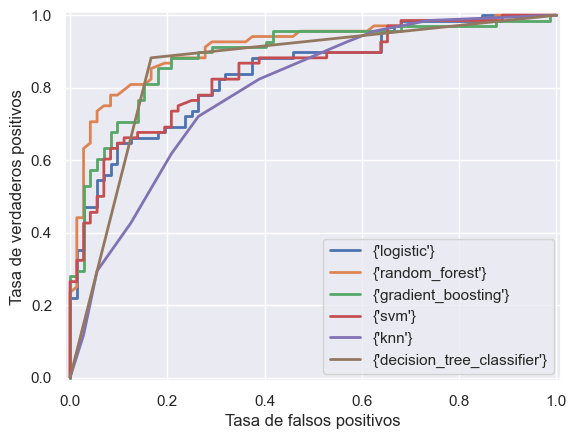

In [24]:
df_result = pd.DataFrame()

df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='logistic')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='random_forest')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='gradient_boosting')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='svm')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='knn')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='decision_tree_classifier')], ignore_index=True)

print(df_result)

Vemos que Random Forest nos da las mejores métricas, por lo que en principio sería nuestro candidato.

In [25]:
randomforest = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
randomforest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

Modelo con todos los atributos AUC: 0.9117647058823529
0.8571428571428571
0.8888888888888888
0.8275862068965517
0.8571428571428572


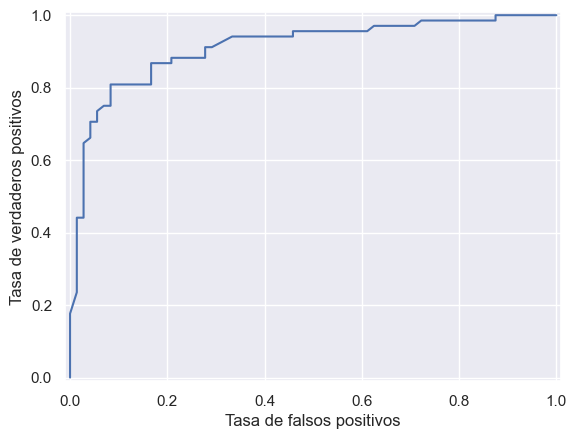

In [26]:
model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)


accuracy_val = accuracy_score(y_pred_val, y_val)
precision_val = precision_score(y_pred_val, y_val)
recall_val = recall_score(y_pred_val, y_val)
f1_val = f1_score(y_pred_val, y_val)

# Calculamos la probabilidad del modelo
prob_total = model.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label=f"Modelo:")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

print(accuracy_val)
print(precision_val)
print(recall_val)
print(f1_val)

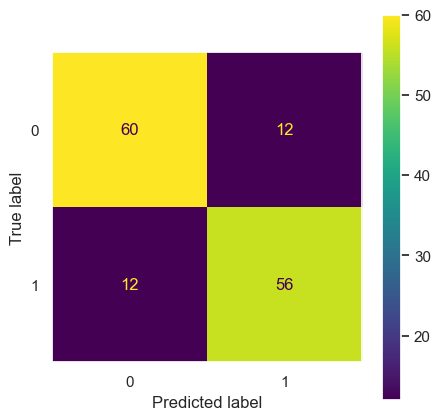

In [27]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);


Decidimos evaluar también una red neuronal para ver si mejoraba nuestros scores.

## Neural Network

In [28]:

import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [29]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForward, self).__init__()  
        self.fc1 = nn.Linear(input_dim, hidden_dim)  
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_dim = 8  
hidden_dim = 32 
output_dim = 1  

net = FeedForward(input_dim, hidden_dim, output_dim)

criterion = nn.BCELoss()
#criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=0.1)

errors = list()
errors_val = list()

# Training loop
for epoch in range(8000):
    values = np.random.permutation(X_train.shape[0])
    val_values = np.random.permutation(X_val.shape[0])

    subsetX = X_train[values[:22], :8]
    subsety = y_train[values[:22]]
    subsetvalX = X_val[val_values[:22], :8]
    subsetvaly = y_val[val_values[:22]]

    optimizer.zero_grad()
    outputs = net(subsetX)

    # Calculate the loss
    loss = criterion(outputs, subsety.float().view(-1, 1))  # BCELoss expects float input and a column vector for targets

    # Backpropagation
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # # Medimos el error de validacion
    outputs_val = net(subsetvalX)
    loss_val = criterion(outputs_val, subsetvaly.reshape([-1, 1]))
    
    errors.append(loss.item())
    errors_val.append(loss_val.item())
    


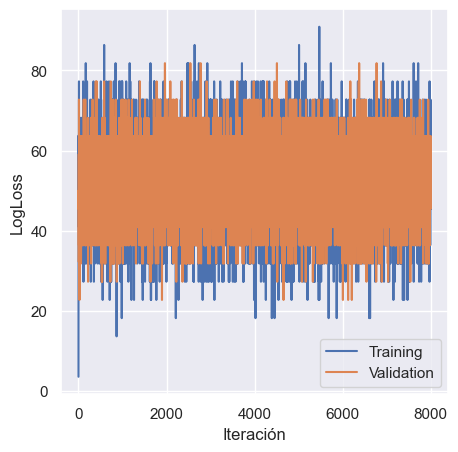

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(errors, label="Training")
ax.plot(errors_val, label="Validation")
ax.set_ylabel("LogLoss")
ax.set_xlabel("Iteración")
ax.legend()
plt.show();

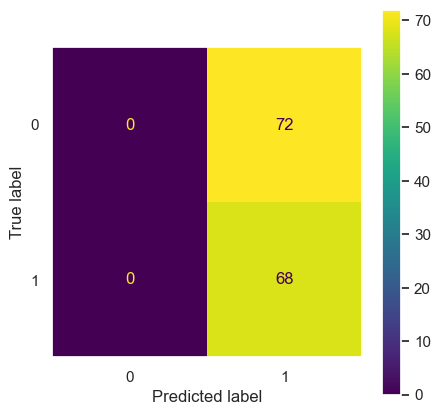

In [32]:
X_test_subset = X_test[:, :8]  # Select the first 7 features
y_prob = net(X_test_subset).detach().numpy().reshape(-1)
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

In [33]:
print(f"El porcentaje de exactitud es de:{accuracy_score(y_test, y_pred)*100: .0f}%")
print(f"Recall de testeo fue: {recall_score(y_test, y_pred)}")

El porcentaje de exactitud es de: 49%
Recall de testeo fue: 1.0


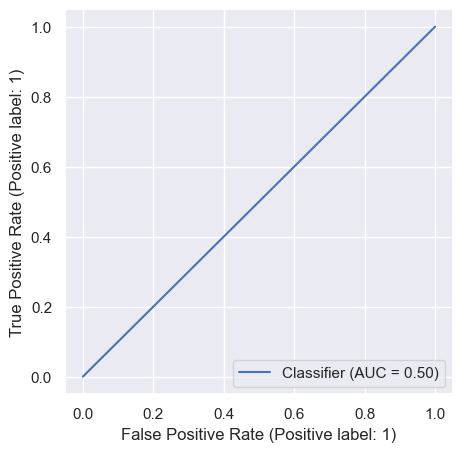

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
svc_disp = RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax)

plt.show()

Vemos que el porcentaje de exactitud usando redes neuronales es muy bajo. Probamos modificando el lr y las capas ocultas pero siempre nos da cercado al 50% de exactitud.

## Análisis y conclusiones:

Durante el trabajo, se propusieron diferentes modelos de Machine Learning y Redes Neuronales para resolver un mismo problema y poder comparar su rendimiento.